In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели
import datetime # для работы со времнем
import gc # сборщик мусора
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='svg'

# 2. Модель
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score

# 3. Метирки качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

In [2]:
# 4. Загрузка обучающего датасета
df = pd.read_csv('train.csv')
#df = reduce_mem_usage(df) # уменьшение занимаемой памяти, если нужно (тут не нужно)
dict(df['DistrictId'].value_counts()) # просмотр по количеству образцов по районам

In [3]:
# 5. Загрузка тестового датасета
X_test = pd.read_csv('test.csv')
#X_test = reduce_mem_usage(X_test)
dict(X_test['DistrictId'].value_counts())

In [4]:
# 6. Некоторая обработка датасетов: выделение целевых данных, создание датафрейма для отправки, установка Id как индекса в сетах
X_train = df.drop('Price', axis=1)
y_train = df[['Price']]

# df для submit
y_predict = pd.DataFrame()
y_predict['Id'] = X_test['Id'].copy()

# установка индекса по Id
X_train.set_index('Id', inplace=True)
X_test.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X_train.shape[0])
print('Строк в тесте', X_test.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


0

In [5]:
# 7. делаем поле DistrcictID строковым (как название)
X_train['DistrictId'] = X_train['DistrictId'].astype(str)
X_test['DistrictId'] = X_test['DistrictId'].astype(str)

In [6]:
# 8. Создаём класс для очистки данных в датасетах
class FeaturesCleaning:
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = self.medians['Rooms'] # !!! медиана посчитана на трейне !!!
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # Square
        X.loc[X['Square'] < 10, 'Square'] = X.loc[X['Square'] < 10, 'Square'] * 10
        X.loc[X['Square'] > 400, 'Square'] = X.loc[X['Square'] > 400, 'Square'] / 10
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] <= 1, 'KitchenSquare'] = self.medians['KitchenSquare']
        X.loc[(X['KitchenSquare'] > 1) & (X['KitchenSquare'] < 3), 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 50, 'KitchenSquare'] = self.medians['KitchenSquare']
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
        
        
        X.loc[X['LifeSquare'] < 10, 'LifeSquare'] = self.medians['LifeSquare']
        X.loc[X['LifeSquare'] > 400, 'LifeSquare'] = self.medians['LifeSquare']
        
        return X

In [7]:
# 9. Делаем очистку данных для обоих датасетов
cleaner = FeaturesCleaning()

cleaner.fit(X_train) # получение медиан для всех фич

X_train = cleaner.transform(X_train) # очистка фич в трейне
X_test = cleaner.transform(X_test) # очистка фич в тесте

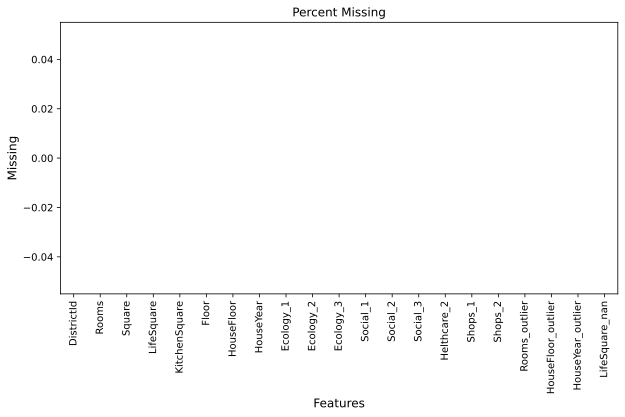

In [8]:
# 10. Проверяем полноту данных в обучающем датасете
nan_df = (X_train.isna().sum() / X_train.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(10,5))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [9]:
# 11. Смотрим статистику данных в обучающем датасете
X_train.describe()

Rooms        Square    LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.000000   
mean       1.888400     56.206777     39.796854       7.396000      7.918200   
std        0.811056     19.081143     18.631029       2.563638      5.186386   
min        1.000000     11.368588     10.523868       3.000000      1.000000   
25%        1.000000     41.784346     26.927003       6.000000      4.000000   
50%        2.000000     52.513310     34.609815       6.000000      7.000000   
75%        2.000000     65.889736     48.103739       9.000000     11.000000   
max        5.000000    275.645284    263.542020      48.000000     42.000000   

        HouseFloor     HouseYear     Ecology_1      Social_1      Social_2  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      12.95910   1984.872400      0.118858     24.687000   5352.157400   
std        6.44346     18.416347      0.119025     17.532614   4006.799803   
min        1.00000   1910.000000      0.000000      0.000000    168.000000   
25%        9.00000   1974.000000      0.017647      6.000000   1564.000000   
50%       13.00000   1977.000000      0.075424     25.000000   5285.000000   
75%       17.00000   2001.000000      0.195781     36.000000   7227.000000   
max      117.00000   2020.000000      0.521867     74.000000  19083.000000   

           Social_3   Helthcare_2       Shops_1  Rooms_outlier  \
count  10000.000000  10000.000000  10000.000000   10000.000000   
mean       8.039200      1.319500      4.231300       0.001200   
std       23.831875      1.493601      4.806341       0.034622   
min        0.000000      0.000000      0.000000       0.000000   
25%        0.000000      0.000000      1.000000       0.000000   
50%        2.000000      1.000000      3.000000       0.000000   
75%        5.000000      2.000000      6.000000       0.000000   
max      141.000000      6.000000     23.000000       1.000000   

       HouseFloor_outlier  HouseYear_outlier  LifeSquare_nan  
count        10000.000000       10000.000000    10000.000000  
mean             0.182500           0.000200        0.211300  
std              0.386275           0.014141        0.408251  
min              0.000000           0.000000        0.000000  
25%              0.000000           0.000000        0.000000  
50%              0.000000           0.000000        0.000000  
75%              0.000000           0.000000        0.000000  
max              1.000000           1.000000        1.000000

In [10]:
# 12. Сохраняем очищенный обучающий датасет
X_train.to_csv('train_clean.csv', index=False, encoding='utf-8')

In [11]:
# 13. Создаём класс новых признаков и трансформации категориальных признаков в цифровые
class FeatureGenetator():
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district_rooms = None
        self.med_price_by_floor_year = None
        self.med_price_by_socials = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 50]  ## анализ показа адекватность параметра, при 30 и 70 становилось хуже
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y_train is not None:
            df['Price'] = y_train.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district_rooms = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrictRooms',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y_train is not None:
            df['Price'] = y_train.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        ## Socials
        if y_train is not None:
            df['Price'] = y_train.values
            df = self.social1_to_cat(df)
            df = self.social2_to_cat(df)
            df = self.social3_to_cat(df)
            self.med_price_by_socials = df.groupby(['social1_cat', 'social2_cat', 'social3_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceBySocials'})
        

        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)  # self.DistrictId_counts = {'id': value}
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # More categorical features
        X = self.floor_to_cat(X)  # + столбец floor_cat
        X = self.year_to_cat(X)   # + столбец year_cat
        X = self.social1_to_cat(X)   # + столбец social1_cat
        X = self.social2_to_cat(X)   # + столбец social2_cat
        X = self.social3_to_cat(X)   # + столбец social3_cat

        
        # Target encoding
        if self.med_price_by_district_rooms is not None:
            X = X.merge(self.med_price_by_district_rooms, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_socials is not None:
            X = X.merge(self.med_price_by_socials, on=['social1_cat', 'social2_cat', 'social3_cat'], how='left')
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1970, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1970) & (X['HouseYear'] <= 1980), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 2000), 'year_cat'] = 4
        
        return X
        
    @staticmethod
    def social1_to_cat(X):
        
        X['social1_cat'] = np.nan
        
        X.loc[X['Social_1'] < 6, 'social1_cat'] = 1
        X.loc[(X['Social_1'] >= 6) & (X['Social_1'] <= 25), 'social1_cat'] = 2
        X.loc[(X['Social_1'] > 25) & (X['Social_1'] <= 36), 'social1_cat'] = 3
        X.loc[(X['Social_1'] > 36), 'social1_cat'] = 4
        
        return X
    
    @staticmethod
    def social2_to_cat(X):
        
        X['social2_cat'] = np.nan
        
        X.loc[X['Social_2'] < 1500, 'social2_cat'] = 1
        X.loc[(X['Social_2'] >= 1500) & (X['Social_2'] <= 5000), 'social2_cat'] = 2
        X.loc[(X['Social_2'] > 5000) & (X['Social_2'] <= 7200), 'social2_cat'] = 3
        X.loc[(X['Social_2'] > 7200), 'social2_cat'] = 4
        
        return X
    
    @staticmethod
    def social3_to_cat(X):
        
        X['social3_cat'] = np.nan
        
        X.loc[X['Social_3'] < 2, 'social3_cat'] = 1
        X.loc[(X['Social_3'] >= 2) & (X['Social_3'] <= 5), 'social3_cat'] = 2
        X.loc[(X['Social_3'] > 5) & (X['Social_3'] <= 20), 'social3_cat'] = 3
        X.loc[(X['Social_3'] > 20), 'social3_cat'] = 4
        
        return X

In [12]:
# 14. Трансформация и генерация новых признаков для обоих датасетов
features = FeatureGenetator()

features.fit(X_train, y_train)

X_train = features.transform(X_train)
X_test = features.transform(X_test)

In [13]:
# 15. Сохранение очищенного и "добавленного" обучающего датасета
X_train.to_csv('train_clean_gen_feat.csv', index=False, encoding='utf-8')

In [14]:
X_train.describe() # просмотр статистики очищенного и "добавленного" обучающего датасета

Rooms        Square    LifeSquare  KitchenSquare         Floor  \
count  10000.000000  10000.000000  10000.000000   10000.000000  10000.000000   
mean       1.888400     56.206777     39.796854       7.396000      7.918200   
std        0.811056     19.081143     18.631029       2.563638      5.186386   
min        1.000000     11.368588     10.523868       3.000000      1.000000   
25%        1.000000     41.784346     26.927003       6.000000      4.000000   
50%        2.000000     52.513310     34.609815       6.000000      7.000000   
75%        2.000000     65.889736     48.103739       9.000000     11.000000   
max        5.000000    275.645284    263.542020      48.000000     42.000000   

        HouseFloor     HouseYear     Ecology_1     Ecology_2     Ecology_3  \
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      12.95910   1984.872400      0.118858      0.990300      0.972500   
std        6.44346     18.416347      0.119025      0.098015      0.163543   
min        1.00000   1910.000000      0.000000      0.000000      0.000000   
25%        9.00000   1974.000000      0.017647      1.000000      1.000000   
50%       13.00000   1977.000000      0.075424      1.000000      1.000000   
75%       17.00000   2001.000000      0.195781      1.000000      1.000000   
max      117.00000   2020.000000      0.521867      1.000000      1.000000   

       ...  DistrictId_count  new_district     floor_cat      year_cat  \
count  ...      10000.000000   10000.00000  10000.000000  10000.000000   
mean   ...        237.316000       0.23540      2.883000      2.485200   
std    ...        273.041493       0.42427      1.193002      1.052944   
min    ...          5.000000       0.00000      1.000000      1.000000   
25%    ...         55.000000       0.00000      2.000000      2.000000   
50%    ...        104.000000       0.00000      3.000000      2.000000   
75%    ...        511.000000       0.00000      4.000000      4.000000   
max    ...        851.000000       1.00000      5.000000      4.000000   

        social1_cat   social2_cat   social3_cat  MedPriceByDistrictRooms  \
count  10000.000000  10000.000000  10000.000000              7646.000000   
mean       2.464800      2.591000      1.791000            195915.315886   
std        1.074279      1.082606      0.918479             64027.294974   
min        1.000000      1.000000      1.000000            102069.270740   
25%        2.000000      2.000000      1.000000            151926.384470   
50%        2.000000      3.000000      2.000000            184648.563531   
75%        3.000000      4.000000      2.000000            217749.656911   
max        4.000000      4.000000      4.000000            595128.195352   

       MedPriceByFloorYear  MedPriceBySocials  
count         10000.000000        9694.000000  
mean         185960.017395      188726.127047  
std           17309.614508       27571.985527  
min          135963.505648      145304.773546  
25%          174590.373323      159768.174822  
50%          180201.521199      187937.455136  
75%          188164.899845      214874.308753  
max          243099.247649      247404.106278  

[8 rows x 30 columns]

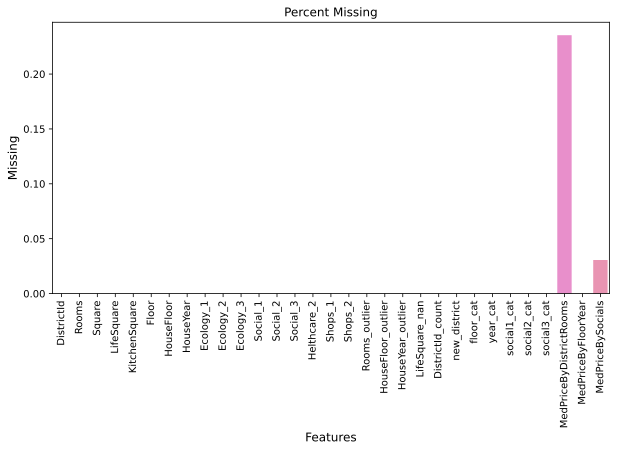

In [15]:
# 16. Проверка очищенного и "добавленного" обучающего датасета на полноту данных
nan_df = (X_train.isna().sum() / X_train.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(10,5))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [16]:
# 17. Сокращаем количество признаков в обоих датасетах (удаление мусорных фич)
remain_features = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'Ecology_1', 'Social_1', 'Shops_1',
                  'Rooms_outlier', 'HouseFloor_outlier', 'HouseYear_outlier', 'LifeSquare_nan',
                   'HouseFloor', 'HouseYear',
                  'DistrictId_count', 'new_district', 'Ecology_2', 'Ecology_3', 'Shops_2',
                  'MedPriceByDistrictRooms',
                  'MedPriceByFloorYear', 'MedPriceBySocials']

X_train = X_train[remain_features]
X_test = X_test[remain_features]

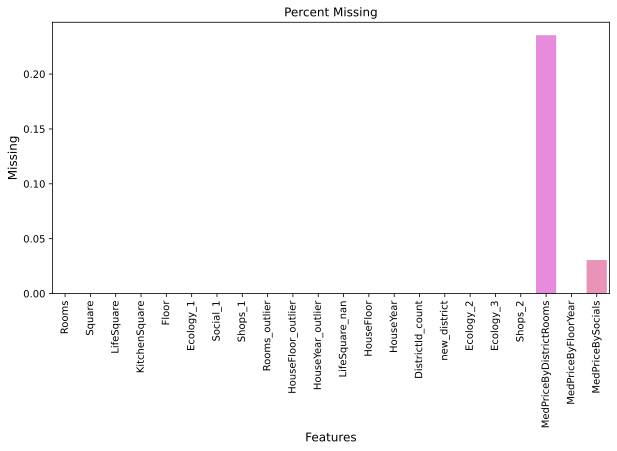

In [17]:
# 16. Проверка очищенного и "добавленного" обучающего датасета на полноту данных после удаления мусорных фич (перестраховка:))
nan_df = (X_train.isna().sum() / X_train.shape[0]).reset_index()
nan_df.columns=['feature', 'nan_percent']

plt.figure(figsize=(10,5))
sns.barplot(nan_df['feature'], nan_df['nan_percent'])
plt.title('Percent Missing')
plt.ylabel('Missing', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.xticks(rotation=90)
plt.show()

In [18]:
# 17. Создание объекта типа LGBMRegressor для поиска оптимальных гиперпараметров
lgb_model = LGBMRegressor(criterion='r2',
                            random_state=42)

In [19]:
# 18. Поиск оптимальных гиперпараметров
params = {'n_estimators':[100, 150, 200, 250],
          'max_depth':[8, 9, 10]}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2', # метрика 
                  cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  # Кол-во потоков - все возможные
                 )
gs.fit(X_train, y_train)  # НА TRAIN!

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             error_score=nan,
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0, criterion='r2',
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, random_state=42,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'max_depth': [8, 9, 10],
                         'n_estimators': [100, 150, 200, 2

In [20]:
gs.best_params_ # демонстрация оптимальных гиперпараметров (min_sample_leaf от 10 до 30 не влиял)

{'max_depth': 8, 'n_estimators': 150}

In [21]:
gs.best_score_ # лучшая метрика при этих гиперпараметрах

0.7443236336817339

In [21]:
# 17. Создание объекта типа LGBMRegressor для обучения нашей модели
model = LGBMRegressor(max_depth=8,
                             min_samples_leaf=10,
                             n_estimators=150,
                             random_state=42)
parameters = [{}]

cv_score = cross_val_score(model, X_train, y_train, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.747 +- 0.017


In [22]:
cv_score # смотрим r2 на фолдах

array([0.72813328, 0.74401741, 0.74114901, 0.74177556, 0.77888836])

In [23]:
# 18. Обучение нашей LGBMRegressor модели на обучающих данных
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=8,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=150, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [24]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)))
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values[:], y=true_values[:])
    plt.plot([0, 600000], [0, 600000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.874


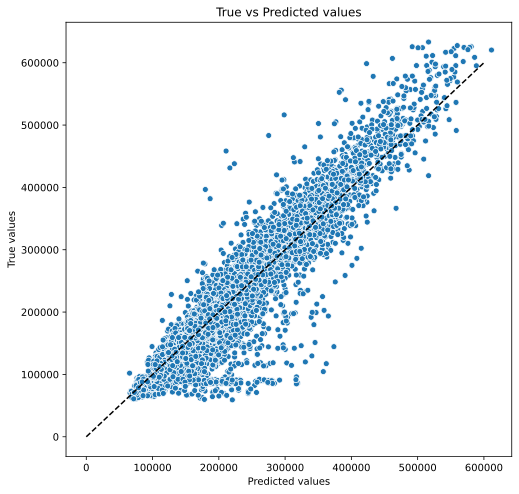

In [25]:
# 19. Смотрим визуально кореляцию реальных и предсказзанных данных
y_train_preds = pd.DataFrame()
y_train_preds = model.predict(X_train)
evaluate_preds(y_train.values.reshape(10000,), y_train_preds)

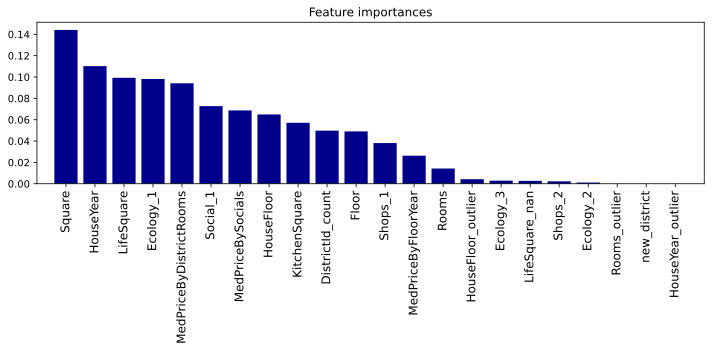

In [26]:
def plot_feature_importances(importances, X_train):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (10, 5))
    plt.title("Feature importances", fontsize=12)
    plt.bar(range(X_train.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation = 90, fontsize=12)
    plt.xlim([-1, X_train.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()
    
plot_feature_importances(importances = model.feature_importances_, X_train=X_train)

In [27]:
# 20. Предсказываем данные для тестового датасета для отправки на соревнование
y_pred = model.predict(X_test)

y_predict['Price'] = y_pred
y_predict.to_csv('predictions.csv', index=False)

y_predict.head()

Id          Price
0    725  153989.012758
1  15856  239786.166271
2   5480  180537.750597
3  15664  317535.407529
4  14275  140337.313275

In [33]:
y_predict.shape # проверка полноты структуры

(5000, 2)